## **University of Toronto - CSC413 - Neural Networks and Deep Learning** 
## **Programming Assignment 4 - StyleGAN2-Ada**

This is a self-contained notebook that allows you to play around with a pre-trained StyleGAN2-Ada generator

Disclaimer: Some codes were borrowed from StyleGAN official documentation on Github https://github.com/NVlabs/stylegan

Make sure to set your runtime to GPU

Remember to save your progress periodically!

In [1]:
# Run this for Google CoLab (use TensorFlow 1.x)
%tensorflow_version 1.x

# clone StyleGAN2 Ada
!git clone https://github.com/NVlabs/stylegan2-ada.git

TensorFlow 1.x selected.
Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Unpacking objects: 100% (71/71), done.


In [2]:
#setup some environments (Do not change any of the following)
import sys
import pickle
import os
import numpy as np
from IPython.display import Image
import PIL.Image
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

sys.path.insert(0, "/content/stylegan2-ada") #do not remove this line

import dnnlib
import dnnlib.tflib as tflib
import IPython.display
from google.colab import files
import imageio

!pip install array2gif
from array2gif import write_gif

Next, we will load a pre-trained StyleGan2-ada network.

Each of the following pre-trained network is specialized to generate one type of image.

In [3]:
# The pre-trained networks are stored as standard pickle files
# Uncomment one of the following URL to begin
# If you wish, you can also find other pre-trained networks online

#URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"      # Human faces
#URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/cifar10.pkl"  # CIFAR10, these images are a bit too tiny for our experiment 
#URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/afhqwild.pkl" # wild animal pictures
#URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/metfaces.pkl" # European portrait paintings
#URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/afhqcat.pkl"  # cats
#URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/afhqdog.pkl"  # dogs
URL = "https://internal.henrytu.me/karras2019stylegan-bedrooms-256x256.pkl"
tflib.init_tf() #this creates a default Tensorflow session

# we are now going to load the StyleGAN2-Ada model 
# The following code downloads the file and unpickles it to yield 3 instances of dnnlib.tflib.Network. 
with dnnlib.util.open_url(URL) as fp:
    _G, _D, Gs = pickle.load(fp) 
# Here is a brief description of _G, _D, Gs, for details see the official StyleGAN documentation 
# _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
# _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
# Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.
# We will work with Gs 

## Part 1 Sampling and Identifying Fakes 

Open: https://github.com/NVlabs/stylegan and follow the instructions starting from *There are three ways to use the pre-trained generator....*

Complete generate_latent_code and generate_images function in the Colab notebook to generate a small row of $3 - 5$ images. 

You do not need to include these images into your PDF submission. 

If you wish, you can try to use https://www.whichfaceisreal.com/learn.html as a guideline to spot any imperfections that you detect in these images, e.g., ``blob artifact" and make a short remark for your attached images. 

In [4]:
# Sample a batch of latent codes {z_1, ...., z_B}, B is your batch size.  
def generate_latent_code(SEED, BATCH, LATENT_DIMENSION = 512):
  """
  This function returns a sample a batch of 512 dimensional random latent code

  - SEED: int
  - BATCH: int that specifies the number of latent codes, Recommended batch_size is 3 - 6
  - LATENT_DIMENSION is by default 512 (see Karras et al.)
  
  You should use np.random.RandomState to construct a random number generator, say rnd
  Then use rnd.randn along with your BATCH and LATENT_DIMENSION to generate your latent codes. 
  This samples a batch of latent codes from a normal distribution 
  https://numpy.org/doc/stable/reference/random/generated/numpy.random.RandomState.randn.html
  
  Return latent_codes, which is a 2D array with dimensions BATCH times LATENT_DIMENSION 
  """
  ################################################################################
  ########################## COMPLETE THE FOLLOWING ##############################
  ################################################################################
  rnd = np.random.RandomState(SEED)

  latent_codes = rnd.randn(BATCH, LATENT_DIMENSION)
  ################################################################################
  return latent_codes

In [7]:
# Sample images from your latent codes https://github.com/NVlabs/stylegan
# You can use their default settings

################################################################################
########################## COMPLETE THE FOLLOWING ##############################
################################################################################
def generate_images(SEED, BATCH, CHECKPOINTS, TRUNCATION = 0.7):
  """
  This function generates a batch of images from latent codes. 
  
  - SEED: int
  - BATCH: int that specifies the number of latent codes to be generated
  - TRUNCATION: float between [-1, 1] that decides the amount of clipping to apply to the latent code distribution
              recommended setting is 0.7

  You will use Gs.run() to sample images. See https://github.com/NVlabs/stylegan for details
  You may use their default setting.  
  """ 
  # Sample a batch of latent code z using generate_latent_code function
  
  latent_codes = None
  og_codes = generate_latent_code(SEED, CHECKPOINTS)

  for i in range(CHECKPOINTS - 1):

    new_latent_codes = np.linspace(og_codes[i], og_codes[i + 1], num=BATCH // CHECKPOINTS)

    if not isinstance(latent_codes, type(None)):
      latent_codes = np.concatenate([latent_codes, new_latent_codes], axis=0)
    else:
      latent_codes = new_latent_codes

  # Convert latent code into images by following https://github.com/NVlabs/stylegan
  fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
  images = Gs.run(latent_codes, None, truncation_psi=TRUNCATION, randomize_noise=True, output_transform=fmt)

  out_images = []
  for i in images:
    out_images.append(i)

  imageio.mimsave('%d.gif' % SEED, out_images)

  return PIL.Image.fromarray(np.concatenate(images, axis=1) , 'RGB')
################################################################################

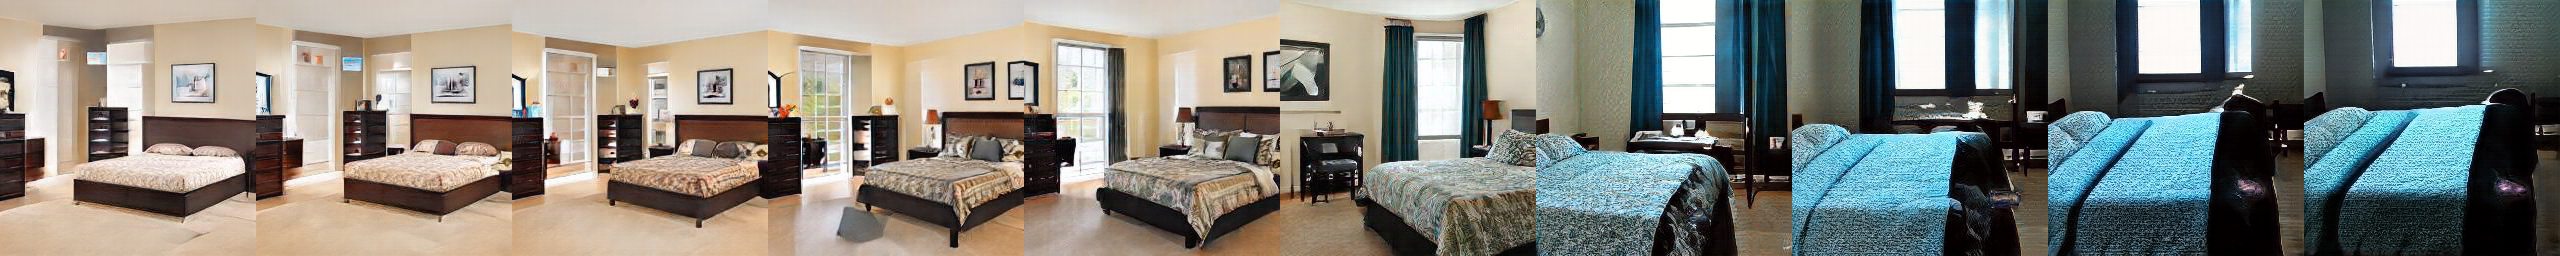

In [12]:
# Generate your images
SEED = 6969420
generate_images(SEED, 20, 2)
#IPython.display.Image(open('%s.gif' % SEED,'rb').read())

In [ ]:
import time

while True:
    time.sleep(10)
    print('look i\'m doing work!')